![simpleresnet.png](simpleresnet.png)

This exercies uses a simple implementation of a deep neural network to explore the vanishing gradient problem

We have provided an example of a very simple feed forward network that has a strongly vanishing gradient w.r.t. the weights that are increasingly close to the input end. 

Your job is to modify the network so that it uses skip connections and make observations on what happens to the gradient after. 

Text(0, 0.5, 'Weight Gradients')

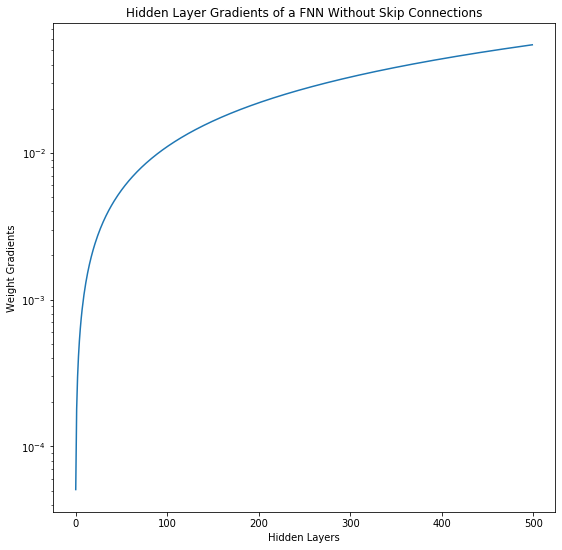

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
torch.manual_seed(0)
import scipy.signal as sp
from torch.utils.data import TensorDataset

# Choose an activation function
activation = torch.tanh

# Choose a number of iterations
n = 500

# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.tensor([1.0])

# Initial value
x = torch.randn((1,),requires_grad=True)
z_prev = x

# Loop over a number of hidden layers
for i in range(n):
    # New weight
    w_i = torch.tensor([1.0],requires_grad=True)

    # Linear transform
    a_i = z_prev*w_i

    # Activation
    zprime_i = activation(a_i)

    z_i = zprime_i
    
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
 
    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad_init = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad_init.append(grad)
    
plt.semilogy(w_grad_init)
plt.title('Hidden Layer Gradients of a FNN Without Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')

Text(0, 0.5, 'Weight Gradients')

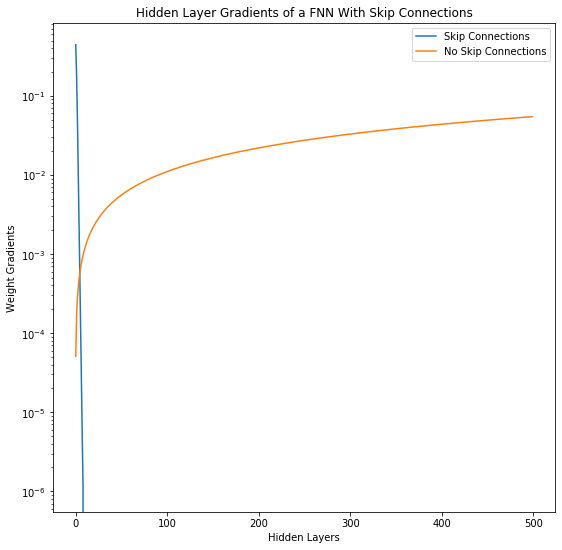

In [3]:
# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.randn((1,))
# Initial value
x = torch.randn((1,),requires_grad=True)
z_prev = x
# Loop over a number of hidden layers

skip1 = 6
skip2 = 17

for i in range(1,n+1):
    # New weight
    w_i = torch.tensor([1.],requires_grad=True)
   
    # Linear transform
    a_i = w_i*z_prev 

    # Activation
    zprime_i = activation(a_i) 
  
    # think about how we would skip multiple layers using MULTIPLE skip lengths in this instance 
    # (hint, use branching and the modulus operator)
    
    z_i = zprime_i + z_prev
    # We found the results to be VERY non-linear
 
    #if i % skip1 == 0:
        #zprime_i.add(a_list[i-skip1])
    
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
    a_list.append(a_i)
    
    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad = []

for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad.append(grad)

plt.semilogy(w_grad,label='Skip Connections')
plt.semilogy(w_grad_init,label='No Skip Connections') #compare to previous network
plt.title('Hidden Layer Gradients of a FNN With Skip Connections')
plt.legend()
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')


Now that we have seen how implementing skip connections seemingly solve the problem of vanishing gradients, we've learned all we can from the paper, lets look at some applications

------------

Below is a simple example of an image processing problem where vanishing gradient becomes an issue (no need to show it this time)

For training and testing data I generated random images for a training and test set. If the small problems are too easy feel free to increase the size of the datasets to make for more challenging problems

After you get done with the conceptual questions below, feel free to change the architecture of the below net. Make 3 changes to the architecture, record the loss difference after 100 iterations, and come up with a justification for that difference in loss

Now we will run an implemenation of a simple deep convolutional network on MNIST (handwritten numbers)

In [2]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_data = train_dataset.data[::20].unsqueeze(1).float()
train_targets = train_dataset.targets[::20].unsqueeze(1)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_data = test_dataset.data[::20].unsqueeze(1).float()
test_targets = test_dataset.targets[::20].unsqueeze(1)

training_data = TensorDataset(train_data,train_targets)
testing_data = TensorDataset(test_data,test_targets)

train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                          batch_size=100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=100,
                                          shuffle=False)



This model allows you to input a specified number of convolutional layers in your network.

In [3]:
# basic net class
class Net(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            x = self.linears[i](zprev)
            zi = F.relu(x)
            zprev = zi
    
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


In [4]:
def train_model(epic, your_net):
        train_accuracy = []
        test_accuracy = []
        
        model = your_net
        model.to(device)

        
        criterion = torch.nn.CrossEntropyLoss()
        
        # since ive set this up as a classification problem with bins number of classes
        optimizer = torch.optim.Adam(model.parameters())

        epochs = epic
        
        # Loop over the data
        for epoch in range(epochs):
                model.train()
                # Loop over each subset of data

                correct = 0
                total = 0        

                for d,t in train_loader:
                        # Zero out the optimizer's gradient buffer
                        optimizer.zero_grad()
                        # Make a prediction based on the model
                        outputs = model(d)
                        # Compute the loss
                        loss = criterion(outputs,t[:,0])
                        # Use backpropagation to compute the derivative of the loss with respect to the parameters
                        loss.backward()
                        # Use the derivative information to update the parameters
                        optimizer.step()

                        
                        _, predicted = torch.max(outputs.data, 1)
                        correct += len(predicted[predicted==t[:,0]])
                        total += len(predicted.flatten())
                                
                correcttest = 0
                totaltest = 0        

                for d,t in test_loader:
                
                    outputs = model(d)
                    _, predicted = torch.max(outputs.data, 1)
                    correcttest += len(predicted[predicted==t[:,0]])
                    totaltest += len(predicted.flatten())
                
                if epoch%10==0:      
                        print(epoch,loss.item(), ' Train_Accuracy = ', correct/total*100,' Test_Accuracy = ', correcttest/totaltest*100)
                
                train_accuracy.append(correct/total*100)
                test_accuracy.append(correcttest/totaltest*100)
        
        return train_accuracy, test_accuracy

You can mess with these paramenters and see how your model performance changes

In [5]:
num_input_images = 100
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
num_epochs = 50 #how long to run the model
num_layers = 15 #how many convolutions to perform

0 2.3600780963897705  Train_Accuracy =  10.266666666666667  Test_Accuracy =  9.2
10 0.49990513920783997  Train_Accuracy =  85.39999999999999  Test_Accuracy =  83.0
20 0.3147647976875305  Train_Accuracy =  90.76666666666667  Test_Accuracy =  85.2
30 0.22943487763404846  Train_Accuracy =  93.43333333333334  Test_Accuracy =  87.8
40 0.19502556324005127  Train_Accuracy =  94.63333333333334  Test_Accuracy =  85.2


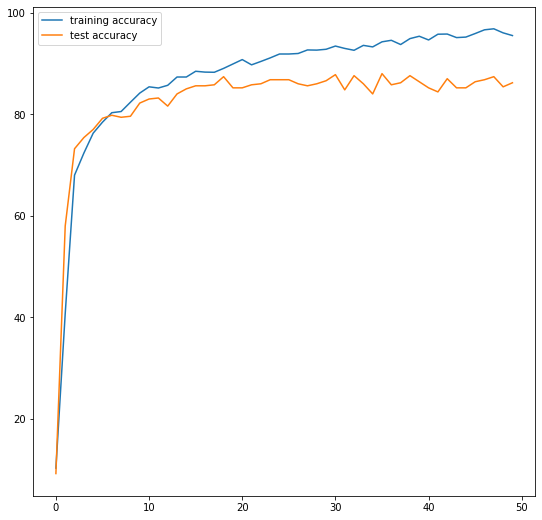

In [6]:
trainacc_init, testacc_init = train_model(num_epochs, Net(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc_init, label = 'training accuracy')
plt.plot(testacc_init, label = 'test accuracy')
plt.legend()
plt.show()

In a similar fashion to what you did on the previous FNN, add skip connects and see if you can improve the model.

In [9]:
# basic net class
skip1 = 2
skip2 = 4

class ResNet(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        #self.linearization1 = nn.Linear(28,28)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
        self.a_list = []
        self.z_list = []
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            #ai = self.linearization(zprev)
          
            ai = self.linears[i](zprev)
            
            # TODO: Implement skip connections in a similar fashion to what was done previously.
            # Think carefully about your skip intervals, and what should be used where
            # hint: use the lists defined as a class object, the modulus operator, and the .add() method
           
            zi = F.relu(ai)
            
            zi = zi + zprev
            
            #if i-skip1 > 0:
                #z_i.add(z_list[i-skip1])

            zprev = zi
            self.z_list.append(zi)
            self.a_list.append(ai)
            
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


0 30.089597702026367  Train_Accuracy =  37.93333333333334  Test_Accuracy =  61.6
10 0.3011356294155121  Train_Accuracy =  94.36666666666666  Test_Accuracy =  80.0
20 0.09424072504043579  Train_Accuracy =  98.83333333333333  Test_Accuracy =  83.39999999999999
30 0.03152813762426376  Train_Accuracy =  99.33333333333333  Test_Accuracy =  84.39999999999999
40 0.0015217993641272187  Train_Accuracy =  97.43333333333334  Test_Accuracy =  85.0


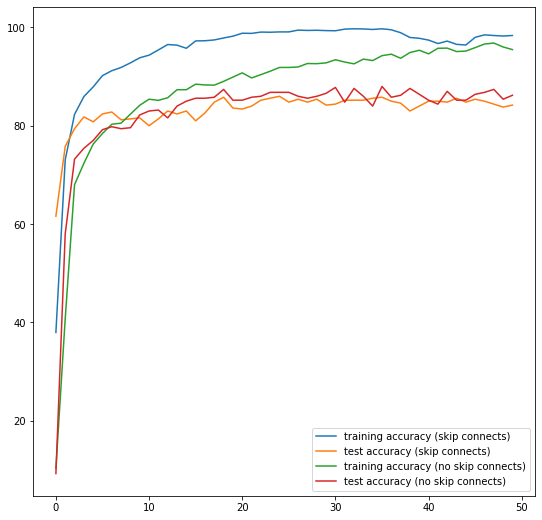

In [10]:
trainacc, testacc = train_model(num_epochs, ResNet(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc, label = 'training accuracy (skip connects)')
plt.plot(testacc, label = 'test accuracy (skip connects)')
plt.plot(trainacc_init, label = 'training accuracy (no skip connects)')
plt.plot(testacc_init, label = 'test accuracy (no skip connects)')
plt.legend()
plt.show()

**Questions**

1. What is the vanishing gradient problem, and what is its primary cause?

The vanishing gradient problem occurs during backpropagation. It is a phenomena that is caused by either very large or very small gradients (i.e. close to infinity or close to zero).

The primary cause is in deep nets (e.g. nets with many hidden layers) during backpropagation we must take many partial derivatives, which in turn requires we multiply many numbers together. When these numbers are larger than one, the product becomes very large. When the numbers are less than one, the product becomes very small.

2. What are 4 limitations to optimizing a deep convolutional neural network?

  a. Degredation problem
  b. computational power
  c. large enough dataset
  d. 

3. In terms of how a given block of a network is "fitted", what is the key difference between using skip connections and traditional blocks?

Skip connections explicitly force the block of the network to fit the residual function

4. In the context of model hyper-parameters, what additional parameters is added in the res-net implementation?

The only new model hyperparamters that are introduced are the length of the skip connection, i.e. how many layers we skip with a particular connection.

5. How do skip connections resolve the "vanishing gradient" problem? (Open Ended)

By explicitly introducing the skip connections, there is something of a 1+gradient_value that is propagated back through the network (as opposed to ONLY the gradient being propagated backwards) 

6. Give an appropriate anology for how kernels are used to extract features from images (i.e. sanding wood)

running a kernel over a picture is akin to smearing all of the pixels together. In this way, the less important/informative features are smoothed away. 

7. Was this a good paper when it was released? Is it a good paper now? What has changed between now and it's initial release point? What other methods are there of solving the vanishing gradient problem? (Open Ended)

They purport that they are not solving the vanishing gradient problem (weight normalization and batch normalization seemed to more or less solve that problem) rather that they are adressing the degredation problem. 

However, it is clear from this exercise that these skip connections also address the vanishing gradient problem while also simulatneously allowing us to train deeper networks to higher generalization accuracy. 

8. What interval of skip connections did you use and where were they applied to? Did you find any #accuracygainz ?

I only used a skip connection interval of 1 at each layer. I did not achieve any sort of gains unless I increased the depth of the networks. Once I did this, the network with skip connections stilll did not outperform the the net without them, but the net without skip connections suffered a loss in accuracy (likely due to degredation).

However, these are still relatively shallow networks. I am almost certain that in deeper archtechuires, skip connections would signifigantly increase test accuracy (as shown in the paper).

Modifications:

Changed activation to sigmoid, this seemed to decrease the overall accuracy by a few percent. This is, in general, to be expected. RELU activations are the current state of the art (which is what the CNN here used originally)

Increase the number of epochs to 100. This did not seem to make much of a difference as both networks were already suffering from overfitting.

Inreased number of layers to 15. This lowered the test accuracy of the network without skip connections while the network with skip conections seemed perform more or less the same.

I think that making the nets much deeper (~30-40 layers or something) would showcase the benfits of skip connections much better. However, this would obviously take alot of computatonal power so this is somewhat infeasible for this exercise. It would also be interesting to see how skip conections work with mcuh more complex problems (MNIST is a good benchmark, but handwritten digit recognition is an easy task, relative to tasks like segmentation).